# ***Threads Craetion & Synchronization***

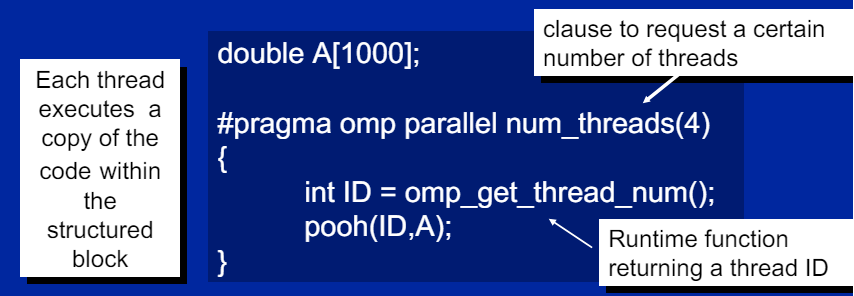

or you can use omp_set_num_threads() also to set number of threads

**Synchronization** is
used to impose order
constraints and to
protect access to
shared data.


   Synchronization critical :
 Mutual exclusion Only one thread at a time
can enter a critical region.

# ***Handy with loop***


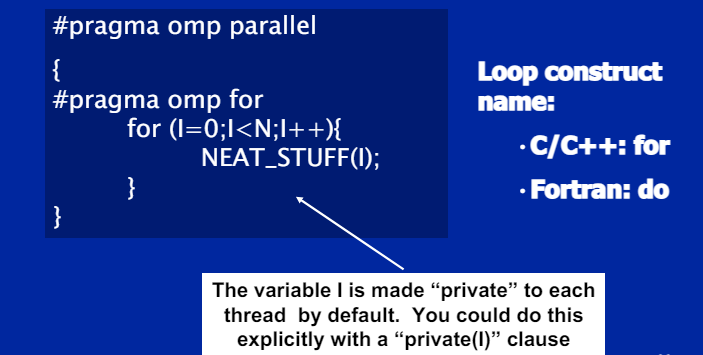



In [2]:
%%writefile for_loop_example.c
#include <stdio.h>
#include <omp.h>

int main() {
    // Define the number of iterations
    int num_iterations = 10;

    // Parallelize the for loop
    #pragma omp parallel for
    for (int i = 0; i < num_iterations; i++) {
        // Get the thread ID
        int thread_id = omp_get_thread_num();

        // Get the total number of threads
        int num_threads = omp_get_num_threads();

        // Print the thread ID and the iteration index
        printf("Thread %d out of %d: iteration %d\n", thread_id, num_threads, i);
    }

    return 0;
}


Writing for_loop_example.c


In [3]:
!gcc -fopenmp for_loop_example.c
!./a.out

Thread 1 out of 2: iteration 5
Thread 1 out of 2: iteration 6
Thread 1 out of 2: iteration 7
Thread 1 out of 2: iteration 8
Thread 1 out of 2: iteration 9
Thread 0 out of 2: iteration 0
Thread 0 out of 2: iteration 1
Thread 0 out of 2: iteration 2
Thread 0 out of 2: iteration 3
Thread 0 out of 2: iteration 4


# ***Monte-Carlo Algorithm: Calculation of PI***

Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

Steps for Calculation:

consider a quadrant (circular sector) inscribed in a unit square. Given that the ratio of their areas is
π
/
4
, the value of π can be approximated using a Monte Carlo method



1.   Draw a square, then inscribe a quadrant within it

2.   Uniformly scatter a given number of points over the square
3.   Count the number of points inside the quadrant, i.e. having a distance from the origin of less than 1
4. The ratio of the inside-count and the total-sample-count is an estimate of the ratio of the two areas,π/4. Multiply the result by 4 to estimate π.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Pi_monte_carlo_all.gif/800px-Pi_monte_carlo_all.gif)

In [4]:
%%writefile monte_carlo.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <time.h>
#include <sys/time.h>

double getRandomNumber(unsigned int *seed) {
    return (double) rand_r(seed) * 2 / (double) (RAND_MAX) - 1;
}

long double SequentialPi(long long iterations) {
    long long numberInCircle = 0;
    unsigned int seed = (unsigned int) time(NULL);

    for (long long int i = 0; i < iterations; i++) {
        double x = getRandomNumber(&seed);
        double y = getRandomNumber(&seed);
        double distanceSquared = x*x + y*y;

        if (distanceSquared <= 1)
        	numberInCircle++;
    }

    return 4 * numberInCircle / ((double) iterations);
}

long double ParallelPi(long long iterations) {
    long long numberInCircle = 0;
	#pragma omp parallel num_threads(4)
	{
    /* Since rand() is not thread-safe, we generate a seed per thread and use rand_r() to
		retrieve a thread-safe random value. */
    	unsigned int seed = (unsigned int) time(NULL) + (unsigned int) omp_get_thread_num();
    	#pragma omp for reduction(+: numberInCircle)
        for (long long int i = 0; i < iterations; i++) {
            double x = getRandomNumber(&seed);
            double y = getRandomNumber(&seed);
            double distanceSquared = x*x + y*y;

            if (distanceSquared <= 1)
            	numberInCircle++;
        }
    }
    return 4 * numberInCircle/((double) iterations);
}

int main() {
    struct timeval start, end;

    long long iterations = 100000000;

    printf("\nTIMING SEQUENTIAL: \n");
    gettimeofday(&start, NULL);
    long double sequentialPi = SequentialPi(iterations);
    gettimeofday(&end, NULL);
    printf("Took %f seconds\n", end.tv_sec - start.tv_sec + (double) (end.tv_usec - start.tv_usec) / 1000000);

    printf("\nTIMING PARALLEL: \n");
    gettimeofday(&start, NULL);
    long double parallelPi = ParallelPi(iterations);
    gettimeofday(&end, NULL);
    printf("Took %f seconds\n\n", end.tv_sec - start.tv_sec + (double) (end.tv_usec - start.tv_usec) / 1000000);

    printf("Sequential: Estimated π = %.10Lf \n", sequentialPi);
    printf("Parallel: Estimated π = %.10Lf \n", parallelPi);

    return 0;
}

Writing monte_carlo.c


In [5]:
!gcc -fopenmp -o monte_carlo_pi monte_carlo.c
!./monte_carlo_pi


TIMING SEQUENTIAL: 
Took 2.384411 seconds

TIMING PARALLEL: 
Took 1.830232 seconds

Sequential: Estimated π = 3.1415416400 
Parallel: Estimated π = 3.1414164000 



![](https://raw.githubusercontent.com/mrigankdoshy/monte-carlo-simulation-pi/master/Pi/Graphs/Parallel%20-%20Threads%20VS%20Time.png)

# ***Matrix Multiplication***

There is a mathematical algorithm for multiplying two matrices, A and B, and creating a matrix C.
![Colab Logo](https://www.learnpdc.org/PDCBeginners/_images/MM-seq.gif)

Because this algorithm is O(N3) in the sequential case, its running time gets very long as N increases. For example, each time we double the size of the rows and columns of the input matrices.

The nature of this algorithm, which calculates cell values row-by-row and independently of each other, lends itself very nicely to be parallelized. The values in the rows of A and the columns of B are only being read from, and each dot product calculation can be done independently- the order of the sequential algorithm’s computations is not necessary.

As an example of how we can use parallelism, suppose we chose two threads to compute the above example of the 4x4 matrices. In the following visualization, a thread 0 can be computing the blue values at the same time that thread 1 is computing the yellow values. It is easy to see how if the parallelization goes well, the work should get done in about half the time as the sequential version, with thread 0 computing the top half of the matrix C (rows 0, 1) and thread 1 computing the lower half (rows 2, 3).
![](https://www.learnpdc.org/PDCBeginners/_images/MM-openMP.gif)

In [6]:
%%writefile mxv_openmp.c
# include <stdlib.h>
# include <stdio.h>
# include <time.h>
# include <omp.h>

int main ( );
void test01 ( int m, int n );
void matgen ( int m, int n, double a[], double x[] );
void mxv_plain ( int m, int n, double a[], double x[], double y[] );
void mxv_plain_openmp ( int m, int n, double a[], double x[], double y[] );
void timestamp ( );

int main ( void )
{
  int i;
  int m;
  int n;

  timestamp ( );

  printf ( "\n" );
  printf ( "MXV_OPENMP:\n" );
  printf ( "  C/OpenMP version\n" );
  printf ( "  Compute matrix vector products y = A*x.\n" );

  printf ( "\n" );
  printf ( "  Number of processors available = %d\n", omp_get_num_procs ( ) );
  printf ( "  Number of threads =              %d\n", omp_get_max_threads ( ) );

  printf ( "\n" );
  printf ( "  Compare various algorithms:\n" );
  printf ( "\n" );
  printf ( "  MXV_PLAIN          - plain MxV coding.\n" );
  printf ( "  MXV_PLAIN_OPENMP  - plain MxV coding + OpenMP.\n" );
  printf ( "\n" );
  printf ( "  Algorithm                  M         N      Seconds\n" );
/*
  N = M
*/
  m = 10;

  for ( i = 1; i <= 3; i++ )
  {
    printf ( "\n" );

    n = m;
    test01 ( m, n );

    m = m * 10;
  }
/*
  N = 10 * M
*/
  m = 1;

  for ( i = 1; i <= 4; i++ )
  {
    printf ( "\n" );

    n = 10 * m;
    test01 ( m, n );

    m = m * 10;
  }
/*
  M = 10 * N
*/
  n = 1;

  for ( i = 1; i <= 4; i++ )
  {
    printf ( "\n" );

    m = 10 * n;
    test01 ( m, n );

    n = n * 10;
  }
/*
  Terminate.
*/
  printf ( "\n" );
  printf ( "MXV_OPENMP:\n" );
  printf ( "  Normal end of execution.\n" );

  printf ( "\n" );
  timestamp ( );

  return 0;
}
void test01 ( int m, int n )

{
  double *a;
  double seconds;
  double *x;
  double *y;

  a = ( double * ) malloc ( m*n * sizeof ( double ) );
  x = ( double * ) malloc (   n * sizeof ( double ) );
  y = ( double * ) malloc ( m   * sizeof ( double ) );

  matgen ( m, n, a, x );

  seconds = omp_get_wtime ( );
  mxv_plain ( m, n, a, x, y );
  seconds = omp_get_wtime ( ) - seconds;
  printf ( "  MXV_PLAIN           %8d  %8d  %14f\n", m, n, seconds );

  seconds = omp_get_wtime ( );
  mxv_plain_openmp ( m, n, a, x, y );
  seconds = omp_get_wtime ( ) - seconds;
  printf ( "  MXV_PLAIN_OPENMP   %8d  %8d  %14f\n", m, n, seconds );

  free ( a );
  free ( x );
  free ( y );

  return;
}
void matgen ( int m, int n, double a[], double x[] )

{
  int i;
  int j;
  int seed;

  seed = 1325;
/*
 Set the matrix A.
*/
  for ( j = 0; j < n; j++ )
  {
    for ( i = 0; i < m; i++ )
    {
      seed = ( 3125 * seed ) % 65536;
      a[i+j*m] = ( seed - 32768.0 ) / 16384.0;
    }
  }
/*
  Set X.
*/
  for ( i = 0; i < n; i++ )
  {
    x[i] = i + 1;
  }

  return;
}

void mxv_plain ( int m, int n, double a[], double x[], double y[] )

{
  int i;
  int j;

  for ( i = 0; i < m; i++ )
  {
    y[i] = 0.0;
    for ( j = 0; j < n; j++ )
    {
      y[i] = y[i] + a[i+j*m] * x[j];
    }
  }

  return;
}

void mxv_plain_openmp ( int m, int n, double a[], double x[], double y[] )


{
  int i;
  int j;

# pragma omp parallel \
  shared ( m, n, a, x, y ) \
  private ( i, j )

# pragma omp for
  for ( i = 0; i < m; i++ )
  {
    y[i] = 0.0;
    for ( j = 0; j < n; j++ )
    {
      y[i] = y[i] + a[i+j*m] * x[j];
    }
  }

  return;
}

void timestamp ( void )

{
# define TIME_SIZE 40

  static char time_buffer[TIME_SIZE];
  const struct tm *tm;
  time_t now;

  now = time ( NULL );
  tm = localtime ( &now );

  strftime ( time_buffer, TIME_SIZE, "%d %B %Y %I:%M:%S %p", tm );

  printf ( "%s\n", time_buffer );

  return;
# undef TIME_SIZE
}

Writing mxv_openmp.c


In [7]:
%%writefile my_script.sh
#!/bin/bash

gcc -fopenmp -pg mxv_openmp.c
if [ $? -ne 0 ]; then
  echo "Compile error."
  exit
fi

gcc -fopenmp -pg mxv_openmp.c
if [ $? -ne 0 ]; then
  echo "Load error."
  exit
fi
rm mxv_openmp.o
mv a.out mxv_openmp

echo "Run with 1 thread."
export OMP_NUM_THREADS=1
echo "OMP_NUM_THREADS=1" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

echo "Run with 2 threads."
export OMP_NUM_THREADS=2
echo "OMP_NUM_THREADS=2" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

echo "Run with 4 threads."
export OMP_NUM_THREADS=4
echo "OMP_NUM_THREADS=4" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

echo "Run with 8 threads."
export OMP_NUM_THREADS=8
echo "OMP_NUM_THREADS=8" >> time_output.txt
(time ./mxv_openmp) 2>> time_output.txt

if [ $? -ne 0 ]; then
  echo "Run error."
  exit
fi

rm mxv_openmp
gprof my_program gmon.out > analysis.txt
echo "Normal end of execution."



Writing my_script.sh


In [8]:
!bash my_script.sh

rm: cannot remove 'mxv_openmp.o': No such file or directory
Run with 1 thread.
19 April 2024 05:55:47 PM

MXV_OPENMP:
  C/OpenMP version
  Compute matrix vector products y = A*x.

  Number of processors available = 2
  Number of threads =              1

  Compare various algorithms:

  MXV_PLAIN          - plain MxV coding.
  MXV_PLAIN_OPENMP  - plain MxV coding + OpenMP.

  Algorithm                  M         N      Seconds

  MXV_PLAIN                 10        10        0.000001
  MXV_PLAIN_OPENMP         10        10        0.000006

  MXV_PLAIN                100       100        0.000040
  MXV_PLAIN_OPENMP        100       100        0.000040

  MXV_PLAIN               1000      1000        0.009093
  MXV_PLAIN_OPENMP       1000      1000        0.009031

  MXV_PLAIN                  1        10        0.000000
  MXV_PLAIN_OPENMP          1        10        0.000004

  MXV_PLAIN                 10       100        0.000004
  MXV_PLAIN_OPENMP         10       100        0.000005